# PRÁCTICA 5.3. INFERENCIA CON REDES CONVOLUCIONALES PRE-ENTRENADAS

En esta práctica, nos centraremos en optimizar y preparar para producción (*deployment*) el modelo de clasificación de perros y gatos que entrenamos en la práctica anterior. Primero, cargaremos nuestro modelo guardado y aplicaremos las herramientas estándar de inferencia en PyTorch: `.eval()` para desactivar capas como el dropout, y `torch.no_grad()` para deshabilitar el cálculo de gradientes. Usaremos `torch.compile()`, el compilador JIT (Just-In-Time) de PyTorch 2.0, para acelerar nuestro modelo fusionando operaciones a bajo nivel.

A continuación, abordaremos el despliegue. Veremos cómo exportar nuestro modelo a un formato universal e independiente de Python utilizando **ONNX** (Open Neural Network Exchange). Este paso nos permite "sellar" el modelo en un archivo que puede ser ejecutado por motores de inferencia en casi cualquier plataforma, como un servidor en C++ o una aplicación móvil. Finalmente, cambiaremos de enfoque y cargaremos un modelo pre-entrenado sobre [ImageNet](http://www.image-net.org) (donde las clases son principalmente de animales y objetos de uso diario), mucho más grande, como VGG16, para analizar su arquitectura y entender cómo podemos usarlo para nuestro caso de uso.

In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## 0. Objetivos
* Hacer inferencia con modelos desde PyTorch: `.eval` y `torch.no_grad`
* Cómo hacer el preprocesamiento correspondiente y el uso de batch obligado.
* Despliegue de modelos con ONNX
* Descarga de un modelo pre-entrenado desde TorchVision (VGG16), y análisis con ejemplos.


## 1. Inferencia con modelos

Para utilizar un modelo entrenado en PyTorch para hacer **inferencia** (predicción), es fundamental seguir una serie de pasos para garantizar que el modelo reciba los datos en el formato que éste espera. El proceso de inferencia se centra en replicar las condiciones del entrenamiento, pero optimizado para velocidad y estabilidad:

1.  Asegurar el **Modo Evaluación** y **Desactivar Gradientes**, mediante `.eval()` y `torch.no_grad()`. Con `model.eval()` desactivamos las capas con comportamiento estocástico como `nn.Dropout` y asegura que `nn.BatchNorm` deje de usar las estadísticas del lote actual y utilice las *estadísticas acumuladas* durante el entrenamiento. Además, debes envolver el pase hacia adelante con `with torch.no_grad():`, ya que esto desactiva el cálculo de gradientes, acelerando la inferencia y reduciendo drásticamente el uso de memoria.

2.  **Preprocesamiento** y Formato del Tensor: La imagen de entrada debe ser preprocesada exactamente de la misma manera que las imágenes de entrenamiento (esto es algo ya que discutimos en el módulo 3). Esto incluye:
    * *Transformaciones:* Redimensionar (`transforms.Resize`), recortar (`transforms.CenterCrop`) y aplicar la normalización (`transforms.Normalize`) con la media y desviación estándar utilizadas durante el entrenamiento (p.ej. las de ImageNet).
    * *Formato de Tensor:* La imagen debe convertirse a un tensor de PyTorch con la forma canónica `(Canal, Alto, Ancho)`.

3.  Dimensiones del **Batch** y **Dispositivo**: Aunque solo tengas una imagen, PyTorch (y la mayoría de los *frameworks* de *deep learning*) esperan las entradas en **lotes (batches)**. Por lo tanto, debes añadir una dimensión al inicio del tensor, transformando la forma a `(1, C, H, W)`** usando `.unsqueeze(0)`. Finalmente, el tensor de entrada debe estar en el mismo dispositivo que el modelo (GPU o CPU) usando `.to(device)`. 

**Ejercicio**: vamos a poner esto en aplicación con el modelo que entrenamos en la práctica anterior. Soluciona los FIXME en el código.


In [ ]:
# Cargamos la definición de bloque convolucional de la práctica anterior
from auxiliar import BloqueConvolucional  

# Cargamos el modelo en la GPU 
model = torch.load('cats_and_dogs_DADB.pth', map_location=device)
# Compilamos el modelo para mejor rendimiento
model = torch.FIXME(model)
#print(model)

def inferencia(image_path):
    img = PIL.Image.open(image_path)
    plt.imshow(img)  
    plt.show()  

    # Preprocesamos la imagen tal y como hicimos con el dataset cats vs dogs
    # Recuerda: normalizábamos a rango [0,1] y reajustamos el tamaño a 150x150
    trans = transforms.Compose([
        FIXME
    ])
    # Aplicamos la transformación
    input_image = FIXME(img)

    # Introducimos la imagen en un batch y lo enviamos a la GPU
    input_batch = input_image.FIXME.to(device)

    # Hacemos inferencia, ¿qué cree el modelo que es?
    # Ponemos el modelo en modo evaluación
    model.FIXME()
    # No calculamos gradientes
    with torch.FIXME():
        pred = FIXME
    # Imprimimos la inferencia del modelo según sigmoide
    print("Es un perro con certeza de un ", F.FIXME(pred).item())

# Leemos una imagen de prueba
inferencia('./imgs/Gemini_dogcat.png')
inferencia('./imgs/Gemini_catdog.png')
inferencia('./imgs/parrot.jpg')

# Eliminamos el modelo, ya que no nos hará falta
del(model)

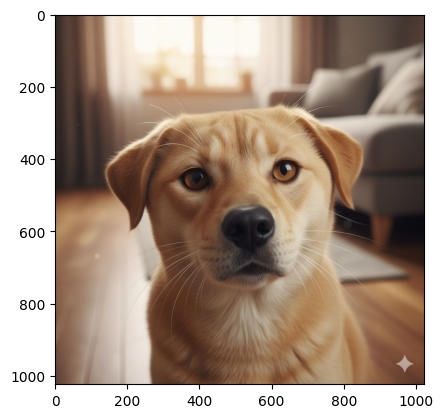

Es un perro con certeza de un  0.9622200131416321


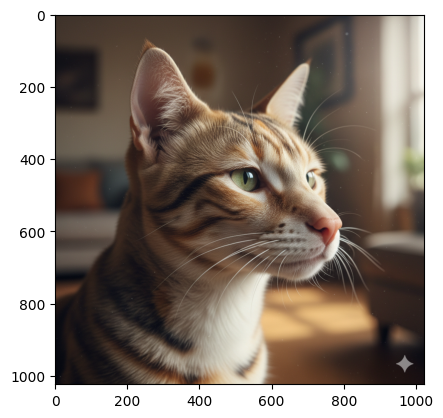

Es un perro con certeza de un  0.0016527725383639336


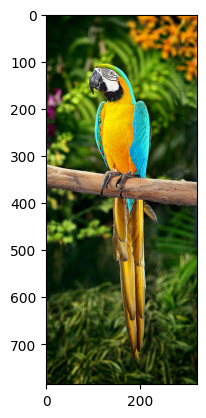

Es un perro con certeza de un  0.9999946355819702


In [4]:
# Solución
# Cargamos la definición de bloque convolucional de la práctica anterior
from auxiliar import BloqueConvolucional  

# Cargamos el modelo en la GPU y lo compilamos
model = torch.load('cats_and_dogs_DADB.pth', map_location=device)
model = torch.compile(model)
#print(model)

def inferencia(image_path):
    img = PIL.Image.open(image_path)
    plt.imshow(img)  
    plt.show()  

    # Preprocesamos la imagen tal y como hicimos con el dataset cats vs dogs
    # Recuerda: normalizábamos a rango [0,1] y reajustamos el tamaño a 150x150
    trans = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])
    input_image = trans(img)

    # Introducimos la imagen en un batch y lo enviamos a la GPU
    input_batch = input_image.unsqueeze(0).to(device)

    # Hacemos inferencia, ¿qué cree el modelo que es?
    model.eval()
    with torch.no_grad():
        pred = model(input_batch)
    # Imprimimos la inferencia del modelo
    print("Es un perro con certeza de un ", F.sigmoid(pred).item())

# Leemos una imagen de prueba
inferencia('./imgs/Gemini_dogcat.png')
inferencia('./imgs/Gemini_catdog.png')
inferencia('./imgs/parrot.jpg')

# Eliminamos el modelo, ya que no nos hará falta
del(model)

## 2. Despliegue de modelos con ONNX

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*sp_qYzIa8PAhzGhXUrVxeQ.png)

[**ONNX**](https://onnx.ai/) (Open Neural Network Exchange) es un formato de código abierto diseñado para la interoperabilidad y portabilidad de redes neuronales. Es por tanto independiente del framework que utilicemos (PyTorch, Keras, Tensorflow, Jax, Scikit-learn...). ONNX actúa como un traductor universal, definiendo un conjunto común de operadores y un formato de archivo estándar. Esto permite a los desarrolladores entrenar en su framework favorito (como PyTorch) y luego desplegar ese modelo en una multitud de entornos diferentes (servidores, dispositivos móviles, navegadores) sin preocuparse por la compatibilidad.

En esta práctica, usaremos ONNX para desplegar nuestro modelo clasificador en producción. Primero, usaremos la función `torch.onnx.export` para exportar nuestro modelo de PyTorch. Este proceso *traza* la arquitectura del modelo usando una entrada de ejemplo y traduce todas las operaciones a un archivo estático `.onnx`. El segundo paso, y el más importante para el despliegue, es que dejaremos de usar PyTorch. Cargaremos ese archivo .onnx usando un motor de inferencia dedicado llamado **ONNX Runtime**. Este runtime es una librería ligera y de alto rendimiento (disponible en Python, C++, Java, etc.) optimizada exclusivamente para ejecutar inferencias de forma eficiente. Demostraremos cómo este runtime puede cargar el modelo y hacer predicciones, probando que es ahora una entidad portable lista para cualquier sistema.

Para reproducir esta última parte, deberás instalar el entorno ONNX Runtime:

In [17]:
!pip install onnx onnxruntime

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 23.4 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [onnxruntime] [onnxruntime]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googleapis-common-protos 1.59.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.33.0 which is incompatible.
tensorflow-metadata 1.13.0 requires protobuf<4,>=3.13, but you have protobuf 6.33.0 which is incompatible.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 6.33.0 which is incompatible.
tensorflow 2.16.1 requires ml-dty

### 2.1 Exportación a ONNX

En el siguiente código cargamos el modelo pre-entrenado.

In [5]:
from auxiliar import BloqueConvolucional  

# Cargamos el modelo en la GPU y lo compilamos
model = torch.load('cats_and_dogs_DADB.pth', map_location=device)

La exportación a ONNX se basa en una traza del modelo. Esto es, el sistema registra las operaciones realizadas cuando se le pasa una imagen de entrada cualquiera. Para ello, se suele pasar una imagen con ruido (generada aleatoriamente).  Esto es necesario para que entender las operaciones que se realizan y poder traducirlas después al formato ONNX.

La exportación se encarga internamente de hacer este trazado. Por otro lado, le debemos dar nombre a las entradas y a las salidas. Hablamos en prural porque hay modelos que pueden obtener varias entradas y/o generar varias salidas. Por último, el exportador crearía un modelo que solo permite tensores de la forma exactamente igual que `dummy_input`. Sin embargo, si queremos permitir que el batch pueda venir con más de una imagen, debemos permitir flexibilidad en dicha dimensión, y esto se indica con `dynamic_axes`.

In [6]:
# Recuerda: seguimos el formato de imágenes de 150x150 dentro de un batch
dummy_input = torch.randn(1, 3, 150, 150).to(device)

fichero_salida = 'cats_and_dogs_DADB.onnx'
print(f"\nExportando a ONNX (guardando en {fichero_salida})...")

torch.onnx.export(
    model,                    # El modelo a exportar
    dummy_input,              # La entrada de ejemplo
    fichero_salida,           # Dónde guardar el archivo
    input_names=['input'],    # Nombre para la entrada
    output_names=['output'],  # Nombre para la salida
    dynamic_axes={'input' : {0 : 'batch_size'},    # Indica que el modelo permite flexibilidad en el eje 0 (el batch!)
                  'output' : {0 : 'batch_size'}}   # Indicamos que esto es así tanto para la entrada como la salida
)

!du -sh cats_and_dogs_DADB.onnx


Exportando a ONNX (guardando en cats_and_dogs_DADB.onnx)...
14M	cats_and_dogs_DADB.onnx


Hacemos una función sencilla para cargar una imagen en un numpy array, con el formato (3,150,150) y los valores normalizados entre 0 y 1.

In [7]:
def load_image(test_image_path):    
    img = PIL.Image.open(test_image_path)
    img = img.resize((150,150), PIL.Image.LANCZOS)
    plt.imshow(img)  
    plt.show()
    img_np = np.array(img)/255                   # Normalizar valores
    img_chw = img_np.transpose(2, 0, 1)          # de (150,150,3) a (3,150.150)
    return img_chw.astype(np.float32)          # el modelo se perparó para float32


### 2.2. Visualización del modelo ONNX

**Ejercicio**: Puedes visualizar el modelo en la web [Netron](https://netron.app/), subiendo tu fichero ONNX. ¿Puedes visualizar las partes que definimos para nuestro modelo? ¿Qué significa `Gemm`?

### 2.3. Despliegue con ONNX Runtime

El siguiente código no utiliza PyTorch, y sería cómo hacerlo con Python. Puedes hacer lo propio en otros lenguajes como Java, C++...
Elegimos primero el motor en CPU o en GPU. Esto no lanza un servidor, sino que directamente llama al motor de ejecución de ONNX Runtime, describiendo el modelo y pasándole un batch de imágenes.

*Nota:* Es verdad que usamos PyTorch para calcular la sigmoide al final, pero esto se podría evitar implementando nuestra propia función sigmoide, o usando cualquier otra librería. Se ha utilizado para simplificar el código.


--- Probando el despliegue con ONNX Runtime ---
Sesión de ONNX Runtime cargada usando: CPUExecutionProvider


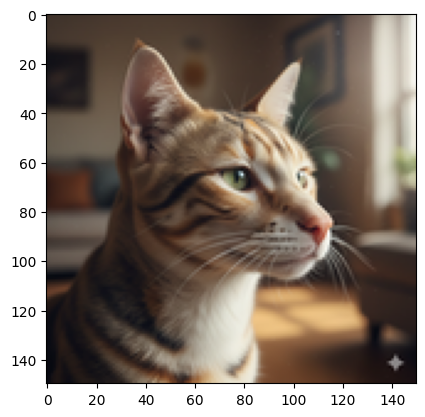

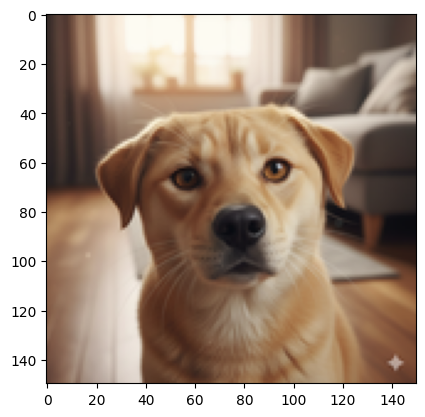

Ejecutando inferencia en ONNX Runtime...

¡Inferencia completada!
Shape de salida: (2, 1)
Salida (logits): [[-7.6528206]
 [ 3.2284646]]
Salida (sigmoid): tensor([[4.7448e-04],
        [9.6189e-01]])


In [8]:
import onnxruntime as ort

# Ahora, olvidémonos de PyTorch.
# Imaginemos que estamos en un servidor (u otro PC) que solo tiene
# el archivo "mi_modelo.onnx" y la librería onnxruntime.
#
print(f"\n--- Probando el despliegue con ONNX Runtime ---")

# 1. Cargar el motor de inferencia
# Si tienes GPU, usa ['CUDAExecutionProvider']
providers = ['CPUExecutionProvider']
if device == "cuda":
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
    
session = ort.InferenceSession(fichero_salida, providers=providers)
print(f"Sesión de ONNX Runtime cargada usando: {session.get_providers()[0]}")

# 2. Preparar una imagen de entrada
# ONNX Runtime espera arrays de NumPy, no tensores de PyTorch
# Vamos a cargar una lista de imágenes y las fusionaremos en un batch
img_list = []
img_list.append(load_image('imgs/Gemini_catdog.png'))
img_list.append(load_image('imgs/Gemini_dogcat.png'))
# Puedes añadir más imágenes al batch
# Ahora creamos el numpy array con el batch
test_image_np = np.stack(img_list, axis=0)
# 3. Preparar los nombres de entrada/salida
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# 4. Ejecutar la inferencia con el motor de ONNX Runtime
# Esto no lanza un servidor, sino que tan solo llama al motor
print(f"Ejecutando inferencia en ONNX Runtime...")
resultado_onnx = session.run(
    [output_name],              # Qué salidas queremos
    {input_name: test_image_np} # Qué entradas le damos
)

print("\n¡Inferencia completada!")
print(f"Shape de salida: {resultado_onnx[0].shape}")
print(f"Salida (logits): {resultado_onnx[0]}")
# Además de los logits, podemos calcular las probabilidades con sigmoid de PyTorch
print(f"Salida (sigmoid): {F.sigmoid(torch.tensor(resultado_onnx[0]))}")

## 3. Clasificación de imágenes con VGG16

En el ejemplo que vamos a ver a continuación consideraremos una CNN entrenada sobre el dataset ImageNet (usando 1,4 millones de imágenes etiquetadas en 1.000 clases diferentes), que contiene clases de muchos animales, en particular diferentes razas de gatos y perros, así que podemos esperar que funcione bien sobre el problema de clasificación que vimos en el ejemplo anterior (Cats and Dogs).

Vamos a usar la arquitectura [VGG16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), desarrollada por Karen Simonyan y Andrew Zisserman en 2014, y que ha sido muy usada desde entonces para este tipo de problemas. Aunque es un modelo un poco viejo, y ya ha sido superado por muchos otros modelos similares, lo usaremos porque hace uso de arquitecturas parecidas a las de ejemplos anteriores, permitiéndonos concentrarnos en las novedades que introduciremos.

![](https://github.com/miguelamda/DL/blob/master/5.%20Redes%20Convolucionales/imgs/vgg16.png?raw=1)

Además del modelo VGG16, Torchvision trae otros modelos preentrenados para clasificación de imágenes, que puedes consultar en la siguiente [tabla](https://docs.pytorch.org/vision/main/models.html#table-of-all-available-classification-weights). Puedes encontrar más modelos en [PyTorch Hub](https://pytorch.org/hub/) (no solo para clasificación de imágenes) y en [timm](https://huggingface.co/docs/timm/index) (modelos de visión de PyTorch).

Primero tendremos que obtener dicho modelo, lo cual es sencillo con PyTorch. A continuación nos descargaremos el modelo VGG16 ya disponible en Torchvision.

In [ ]:
weights = models.VGG16_Weights.DEFAULT
modeloVGG16 = models.vgg16(weights=weights)

#modeloVGG16 = models.vgg16(pretrained=True)  #Forma alternativa en desuso.

Para mejorar el rendimiento del modelo, vamos a moverlo a la GPU y compilarlo:

In [10]:
modeloVGG16 = torch.compile(modeloVGG16.to(device))

Vamos a definir una serie de funciones auxiliares que nos ayudarán en la tarea de clasificar imágenes. Por un lado, necesitamos una función que preprocese las imágenes previo a pasarlas por la red, aplicando las transformaciones que se le aplicaron a ImageNet para entrenar dicho modelo (básicamente estandarlizado con la media y desviación de todo el dataset Imagenet).  Por otro lado, necesitamos decodificar las clases. Ahora tenemos 1000 clases, es imposible recordarlas todas, por lo que usar tan solo el índice de la clase no es suficiente, necesitamos los nombres de las etiquetas. Por último, haremos una función que: muestre la imagen, la clasifica usando el modelo cargado, e imprime las puntuaciones (scores) de clasificación. 

Por suerte, podemos conseguir fácilmente la información mencionada a traves del objeto de pesos (`weights`) disponible en Torchvision. Este objeto contiene más metadatos que los incluidos dentro del modelo descargado, incluyendo las transformaciones y los nombres de las clases. A continuación puedes ver cómo conseguir la transformación requerida para las imágenes.

In [ ]:
# obtenemos las transformaciones que se aplicaron a las imágenes
transforms = weights.transforms()

El modelo nos dará la probabilidad de que una imagen pertenezca a cada clase. Sin embargo, si la clase con el mayor valor de probabilidad es la clase número 674, qué significa? Qué clase es la 674? El objeto `weights` también incluye una lista que indica el nombre de cada clase para nuestro modelo, tan solo tenemos que indexarla. A continuación definimos una función que toma los k valores más altos y los decodifica.

In [ ]:
import torch.nn.functional as F

# Lista con nombre de clases de ImageNet, en el orden usado por VGG16
vgg16_class_names = weights.meta["categories"]

def decode_topk_predictions(output_tensor, class_names, k=5):    
    
    # 1. Aplicamos Softmax a los logits generados por el modelo
    # ¡Softmax trabaja con batches! Por eso usamos unsqueeze
    probabilities = F.softmax(output_tensor, dim=1) 
    
    # 2. Top-K (encuentra los K mejores)
    topk_prob, top_class_indices = torch.topk(probabilities, k=k, dim=1)
    
    # 3. Decodificación de los ejemplos en el batch
    for j in range(topk_prob.size(0)):
        print("\n--- Top ",k," Predicciones Imagen ",j," ---")
        for i in range(topk_prob[j].size(0)):
            # Obtiene el índice y el nombre de la clase
            score = topk_prob[j][i].item()
            class_index = top_class_indices[j][i].item()
            
            # Aquí asumimos que class_map devuelve el nombre legible
            name = class_names[class_index]
            
            # Imprime la predicción formateada
            print("{0:>6.2%} : {1}".format(score, name))
    return topk_prob, top_class_indices

Finalmente, esta función funciona de forma parecida a `infiere` que hemos hecho antes, pero trabaja con VGG16 y con clases de ImageNet.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL

def predict(model,image_path):
    # Carga y redimensiona la imagen usando PIL.
    img = PIL.Image.open(image_path)
    
    # Redimensionamos a tamaño de ImageNet para visualizar cómo
    # queda la imagen
    img_resized = img.resize((224,224), PIL.Image.LANCZOS)

    # Dibuja la imagen.
    plt.imshow(img_resized)
    plt.axis(False)
    plt.show()

    # Convierte la imagen PIL a un numpy-array con la forma (shape) apropiada.
    #img_array = preprocess_image(img)
    img_array = transforms(img)

    # Añade una dimensión de batch: (C, H, W) -> (1, C, H, W)
    input_batch = img_array.unsqueeze(0)

    # Mueve la entrada a la GPU
    input_batch = input_batch.to(device)

    # --- INFERENCIA ---
    # Modelo en modo evaluación (desactiva Dropout y BatchNorm)
    model.eval() 
    
    # Usa el modelo VGG16 para hacer la predicción.
    # Esto devuelve un array con 1000 números, correspondientes a
    # las clases del dataset ImageNet.
    with torch.no_grad():                   
        output_batch = model(input_batch) 
    
    # Pasa las salidas de vuelta a la CPU si estaban en GPU
    output_batch = output_batch.cpu()

    # Decodifica la salida del modelo VGG16.
    decode_topk_predictions(output_batch,vgg16_class_names)

**Ejercicio opcional**: amplía la función anterior para que no solo cargue una imagen, sino una lista de imágenes, y las pase al modelo en un solo batch.

Usemos el modelo VGG16 en la foto del loro que debería ser clasificado como guacamayo (macaw, una especie de loro).

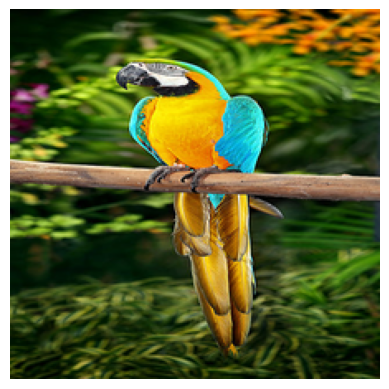


--- Top  5  Predicciones Imagen  0  ---
99.73% : macaw
 0.24% : toucan
 0.03% : bee eater
 0.00% : hornbill
 0.00% : lorikeet


In [19]:
predict(model=modeloVGG16,image_path='imgs/parrot.jpg')

El modelo VGG16 funciona con imágenes de entrada de 224 x 224 píxeles de tamaño. La imagen de arriba de un loro tiene en realidad 320 píxeles de ancho y 785 píxeles de alto, por lo que es redimensionada automáticamente para el modelo VGG16. Podemos ver que ha sido apretado para que sea cuadrado, y la resolución se ha reducido para que la imagen sea más pixelada y granulada.

En este caso, el modelo VGG16 acierta clasificando la imagen como un guacamayo con un 99,7%, y un tucán con un solo 0,24%.

### Imagen Recortada, arriba

Esta imagen del loro se ha recortado manualmente a una dimensión cercana a 224 x 224 píxeles y luego se ha introducido en el modelo. VGG16 está aún más seguro (puntuación del 99,99%) de que muestra un guacamayo.

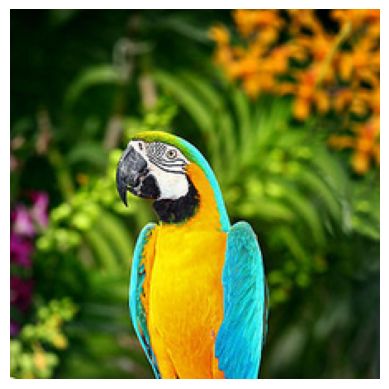


--- Top  5  Predicciones Imagen  0  ---
99.99% : macaw
 0.00% : peacock
 0.00% : hornbill
 0.00% : lorikeet
 0.00% : toucan


In [20]:
predict(model=modeloVGG16,image_path='imgs/parrot_cropped1.jpg')

### Imagen Recortada, en el centro

Esto es otro recorte de la imagen del loro, esta vez mostrando su cuerpo sin cabeza ni cola. El modelo VGG16 tiene un poco menos de confianza (puntuación de alrededor del 98%) de que muestra un loro guacamayo. El modelo debe haber aprendido a detectarlo más por la cabeza, no por su su cuerpo.

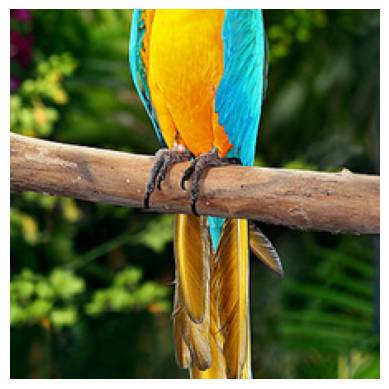


--- Top  5  Predicciones Imagen  0  ---
98.25% : macaw
 1.72% : toucan
 0.01% : hornbill
 0.01% : bee eater
 0.00% : lorikeet


In [21]:
predict(model=modeloVGG16,image_path='imgs/parrot_cropped2.jpg')

### Imagen Recortada, abajo

Esta imagen ha sido recortada por lo que sólo muestra la cola del loro. Ahora el modelo VGG16 está confundido, piensa que podría tratarse de una mantis con un 25%, y un macaw con solo un 8%, también podría mostrar un merópido con un 17% y un jacamar con un 8%, que son otras aves exóticas. 

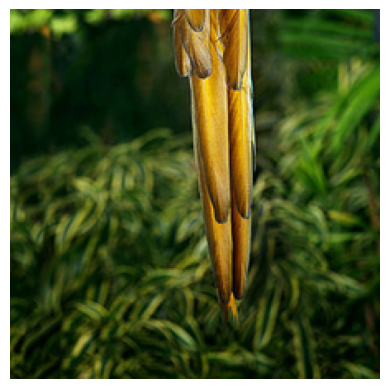


--- Top  5  Predicciones Imagen  0  ---
25.65% : mantis
17.02% : bee eater
 8.77% : jacamar
 8.40% : macaw
 8.10% : hornbill


In [22]:
predict(model=modeloVGG16,image_path='imgs/parrot_cropped3.jpg')

### Imagen Rellenada

La mejor manera de introducir imágenes es rellenar la imagen para que sea cuadrada (en blanco a los lados) y luego redimensionarla a 240 x 240 píxeles. Sin embargo, este ejemplo del guacamayo baja a un 97%. 

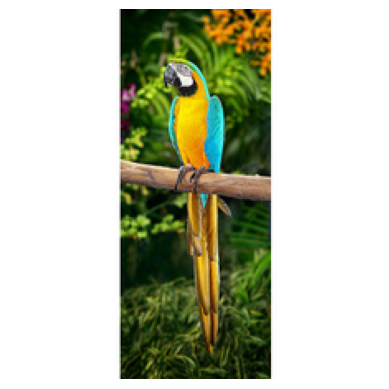


--- Top  5  Predicciones Imagen  0  ---
97.38% : macaw
 1.01% : lorikeet
 0.79% : bee eater
 0.64% : toucan
 0.14% : jacamar


In [23]:
predict(model=modeloVGG16,image_path='imgs/parrot_padded.jpg')

### Elon Musk

#### 299 x 299 píxeles

Esta imagen muestra al empresario, fundador de Tesla y SpaceX, Elon Musk. Pero el modelo de VGG16 está muy confundido sobre lo que muestra la imagen, prediciendo que puede mostrar una pelota de rugby (9%), o un teléfono móvil (5%). Por lo tanto, el modelo está confuso y las puntuaciones de la clasificación son ruido y no son fiables.

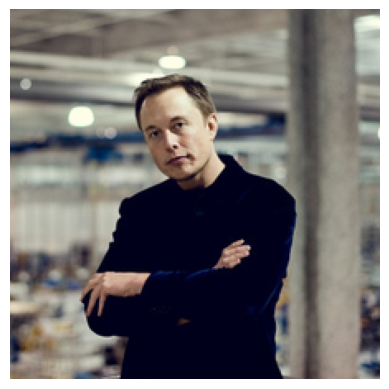


--- Top  5  Predicciones Imagen  0  ---
 9.33% : rugby ball
 5.45% : cellular telephone
 5.02% : jersey
 4.64% : ping-pong ball
 4.02% : ballplayer


In [24]:
predict(model=modeloVGG16,image_path='imgs/elon_musk.jpg')

#### 100 x 100 píxeles

Si en su lugar usamos una imagen de 100 x 100 píxeles de Elon Musk, entonces el modelo piensa que podría mostrar un chaleco antibalas con un 6%. El modelo VGG16 tiene predicciones diferentes, y sigue estando algo confuso.

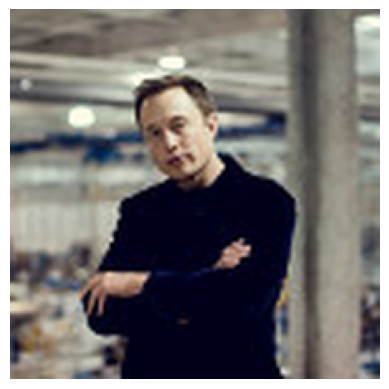


--- Top  5  Predicciones Imagen  0  ---
 6.09% : bulletproof vest
 6.00% : potter's wheel
 3.97% : trench coat
 3.20% : sturgeon
 3.11% : jersey


In [25]:
predict(model=modeloVGG16,image_path='imgs/elon_musk_100x100.jpg')

### Willy Wonka 

#### Gene Wilder

Esta imagen muestra al actor Gene Wilder interpretando a Willy Wonka en la versión de la película de 1971. El modelo VGG16 está muy seguro de que la imagen muestra una pajarita (bow tie, puntuación de alrededor del 50%), lo que es cierto, pero un humano probablemente diría que esta imagen muestra a una persona.

La razón podría ser que el modelo fue entrenado en imágenes de personas con pajaritas que fueron clasificadas como pajaritas en lugar de personas. Así que tal vez el problema es que el nombre de la clase debería ser "persona con pajarita" en lugar de sólo "pajarita".

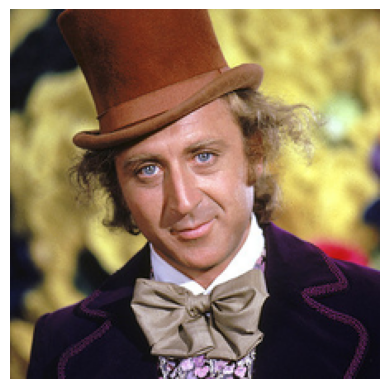


--- Top  5  Predicciones Imagen  0  ---
50.19% : bow tie
23.64% : cowboy hat
 6.13% : military uniform
 5.31% : suit
 2.95% : bolo tie


In [26]:
predict(model=modeloVGG16,image_path='imgs/willy_wonka_old.jpg')

#### Johnny Depp

Esta imagen muestra al actor Johnny Depp interpretando a Willy Wonka en la versión de 2005 de la película. El modelo piensa que esta imagen muestra "gafa de sol" (sunglass, puntuación aproximada del 38%) o "gafas de sol" (sunglusses, puntuación aproximada del 35%). El modelo VGG16 ha sido entrenado para reconocer gafas de sol enfocado en los ojos, y no a personas. 

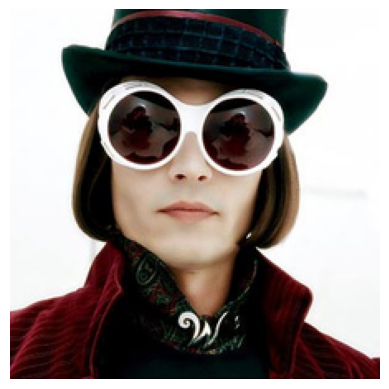


--- Top  5  Predicciones Imagen  0  ---
38.86% : sunglass
35.97% : sunglasses
 3.62% : wig
 1.41% : bonnet
 1.28% : stole


In [27]:
predict(model=modeloVGG16,image_path='imgs/willy_wonka_new.jpg')

**Ejercicio**: Desarrolla a continuación una función que utilice VGG16 para clasificar perros y gatos:
* Puedes probar con cualquier imagen dentro de `./data/cat_dogs/test`.
* La clasificación de la imagen se debe basar en el top-1; es decir, la clase con el mayor valor de probabilidad. Para ello puedes usar directamente la función `argmax` de los tensores, en vez de la función `decode_topk_predictions`.
* Ten en cuenta que en ImageNet, las clases desde la 151 a la 268 son perros, y los gatos son las clases desde la 281 a la 285.
* Basándote en la función `predict` anterior, desarrolla la función `predict_cat_dog` para que imprima por pantalla el mensaje `Es un perro`, `Es un gato`, o `Es otra cosa`, según el caso.

In [ ]:
# Desarrolla aquí tu código
def predict_cat_dog(model,image_path):
   print("Sin definir")
   return None

predict_cat_dog(model=modeloVGG16,image_path='data/cat_dogs/test/cats/1500.jpg')
predict_cat_dog(model=modeloVGG16,image_path='data/cat_dogs/test/dogs/1500.jpg')
predict_cat_dog(model=modeloVGG16,image_path='imgs/creative_commons_elephant.jpg')

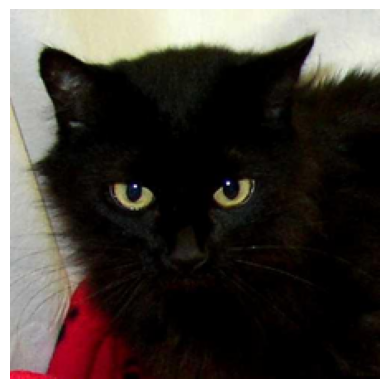

Es un gato


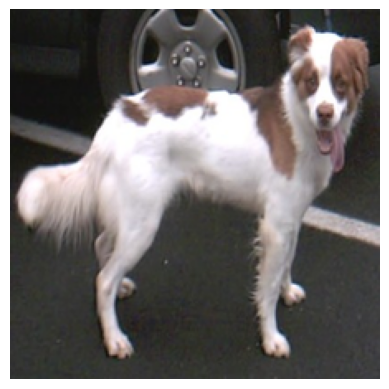

Es un perro


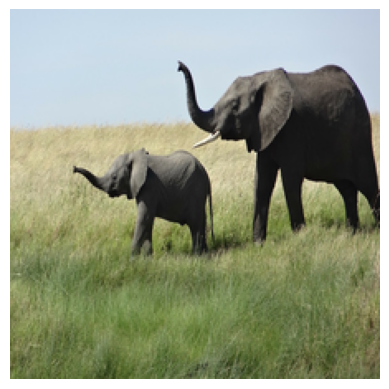

Es otra cosa


: 

In [ ]:
# Solución
def predict_cat_dog(model,image_path):
    # Carga y redimensiona la imagen usando PIL.
    img = PIL.Image.open(image_path)
    
    # Redimensionamos a tamaño de ImageNet para visualizar cómo
    # queda la imagen
    img_resized = img.resize((224,224), PIL.Image.LANCZOS)

    # Dibuja la imagen.
    plt.imshow(img_resized)
    plt.axis(False)
    plt.show()

    # Convierte la imagen PIL a un numpy-array con la forma (shape) apropiada.
    img_array = transforms(img)

    # Añade una dimensión de batch: (C, H, W) -> (1, C, H, W)
    input_batch = img_array.unsqueeze(0)

    # Mueve la entrada a la GPU
    input_batch = input_batch.to(device)

    # --- INFERENCIA ---
    # Modelo en modo evaluación (desactiva Dropout y BatchNorm)
    model.eval() 
    
    # Usa el modelo VGG16 para hacer la predicción.
    # Esto devuelve un array con 1000 números, correspondientes a
    # las clases del dataset ImageNet.
    with torch.no_grad():                   
        output_batch = model(input_batch) 
    
    # --- SOLUCIÓN ---
    # Extrae la clasificación top-1 de la imagen
    idx = output_batch.argmax(dim=1).item()

    if 151 <= idx <= 268:
        print("Es un perro")
    elif 281 <= idx <= 285:
        print("Es un gato")
    else:
        print("Es otra cosa")

predict_cat_dog(model=modeloVGG16,image_path='data/cat_dogs/test/cats/1500.jpg')
predict_cat_dog(model=modeloVGG16,image_path='data/cat_dogs/test/dogs/1500.jpg')
predict_cat_dog(model=modeloVGG16,image_path='imgs/creative_commons_elephant.jpg')

## 4. Conclusiones y Bibliografía

Ahora ya sabes los detalles a tener en cuenta a la hora de cargar un modelo y emplearlo en producción. También hemos visto cómo exportar modelos al formato estándar ONNX, y cómo poner un modelo en producción con ONNX Runtime. Por último, hemos cargardo el modelo VGG16 y lo hemos analizado al detalle. En la siguiente práctica veremos cómo hacer transfer learning con VGG16.

Para poner modelos en producción existen muchísimas más plataformas. Por ejemplo, [TensorRT](https://developer.nvidia.com/tensorrt) de NVIDIA permite tanto optimizar los modelos para sus GPUs, así como ejecutar su runtime para inferencia. Para lanzar modelos en entornos cloud de alto rendimiento, NVIDIA ofrece la herramienta [Triton](https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/introduction/index.html), que también es compatible con árboles de decisión de tipo Boosting.

* [Tutorial ONNX PyTorch](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)